- - - -
# Mechpy Tutorials
a mechanical engineering toolbox

source code - https://github.com/nagordon/mechpy  
documentation - https://nagordon.github.io/mechpy/ 

- - - -

Neal Gordon  
2017-02-20  

- - - -

## An Example of composite plate mechanics with python

Neal Gordon  
2017-2-20  

THESE RESULTS NEED TO BE CONFIRMED!!!

This is an example of a composite plate with a pressure applied to the top. It also showcases python's symbolic library sympy to  solve the differential equations of the comopsite plate theory

References  
1) Hyer, Stress Analysis of Fiber-Reinforced Composites Materials  
2) Reddy, Mechanics of Laminated Composite Plates and Shells  

In [63]:
# Import Python modules and 
import numpy as np
from numpy import zeros, ones, linspace, arange, array
from numpy.linalg import inv

import sympy as sp
from sympy.plotting import plot3d
from sympy import symbols, solve, diff, Matrix

from pprint import pprint

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import matplotlib as mpl
# printing and plotting settings 
sp.init_printing(use_latex='mathjax')
get_ipython().magic('matplotlib inline') # inline plotting

#mpl.rcParams['figure.figsize'] = (12,7)
#mpl.rcParams['font.size'] = 14
#mpl.rcParams['legend.fontsize'] = 14

In [64]:
# import mechpy modules
from composites import Qf, T1, T2, T1s, T2s

In [65]:
# Define Material Properties and compute ABD matrix

plythk = 0.0025
plyangle = array([0,45]) * np.pi/180 # angle for each ply  # [0,90,-45,45,0][0 45 -45 90 0]
nply = len(plyangle) # number of plies
laminatethk = zeros(nply) + plythk
H =   sum(laminatethk) # plate thickness
# Create z dimensions of laminate
z_ = zeros(nply+1); z_[0] = -H/2
zmid_ = zeros(nply)
for i in range(nply):
    z_[i+1] = z_[i] + laminatethk[i]
    zmid_[i] = z_[i] + laminatethk[i]/2

a_ =   20  # plate width;
b_ =   10  # plate height
q_ = -5.7 # plate load;
# Transversly isotropic material properties
E1 = 150e9
E2 = 12.1e9
nu12 = 0.248
G12 = 4.4e9
nu23 = 0.458
G23 = E2 / (2*(1+nu23))
# Failure Strengths
F1t =  1500e6
F1c = -1250e6
F2t =  50e6
F2c = -200e6
F12t =  100e6
F12c =  -100e6
Strength = array([[F1t, F1c],
                    [F2t, F2c],
                    [F12t, F12c]])

A = zeros((3,3)); B = zeros((3,3)); D = zeros((3,3))  
Q = Qf(E1, E2, nu12, G12 )
for i in range(nply):  # = nply
    Qbar = inv(T1(plyangle[i])) @ Q   @ T2(plyangle[i]) # solve(T1(plyangle[i]), Q) @ T2(plyangle[i])
    A += Qbar*(z_[i+1]-z_[i])
    # coupling  stiffness
    B += (1/2)*Qbar*(z_[i+1]**2-z_[i]**2)
    # bending or flexural laminate stiffness relating moments to curvatures
    D += (1/3)*Qbar*(z_[i+1]**3-z_[i]**3)  

In [66]:
A

array([[  7.5361e+08,   1.5144e+07,   4.7596e+06],
       [  1.5144e+07,   6.0801e+07,  -1.0910e+04],
       [  4.7596e+06,  -1.0910e+04,   2.2065e+07]])

In [67]:
B

array([[ -1.6314e+02,   8.1763e+01,   5.9495e+03],
       [  8.1763e+01,  -3.8927e-01,  -1.3638e+01],
       [  5.9495e+03,  -1.3638e+01,   8.1763e+01]])

In [68]:
D

array([[  1.5700e+03,   3.1550e+01,   9.9159e+00],
       [  3.1550e+01,   1.2667e+02,  -2.2729e-02],
       [  9.9159e+00,  -2.2729e-02,   4.5970e+01]])

In [69]:
A11_ = A[0,0]
B11_ = B[0,0]
D11_ = D[0,0]

In [70]:
# declare symbols for equation generation
#x,y,q = symbols('x,y,q')
th,x,y,z,q,a,b,C1,C2,C3,C4,C5,C6 = symbols('th,x,y,z,q,a,b,C1,C2,C3,C4,C5,C6')
strainx, strainy, strainxy, stressx, stress, stressxy = symbols('epsilonx,epsilony,gammaxy,sigmax,sigmay,sigmaxy')
ex,ey,exy,sx,sy,sxy = symbols('epsilon_x, epsilon_y, gamma_xy,sigma_x,sigma_y,tau_xy')

A11,A22,A66,A12,A16,A26,A66 = symbols('A11,A22,A66,A12,A16,A26,A66')
B11,B22,B66,B12,B16,B26,B66 = symbols('B11,B22,B66,B12,B16,B26,B66')
D11,D22,D66,D12,D16,D26,D66 = symbols('D11,D22,D66,D12,D16,D26,D66')
Nx,Ny,Nxy,Mx,My,Mxy = symbols('Nx,Ny,Nxy,Mx,My,Mxy')

##if use this, then reference  the function as u0(x), example  diff(u0(x),x,2)
#
#u0 = Function('u0')(x,y)
#v0 = Function('v0')(x,y)
#w0 = Function('w0')(x,y)

In [71]:
w0 = A11 / (A11*D11-B11**2) * ( q*x**4/24 - C2*x**3/6 - (C3- B11/A11*C1)*x**2/2 - C5*x - C6 )
w0

    ⎛                              2 ⎛     B₁₁⋅C₁⎞⎞
    ⎜      3                  4   x ⋅⎜C₃ - ──────⎟⎟
    ⎜  C₂⋅x                q⋅x       ⎝      A₁₁  ⎠⎟
A₁₁⋅⎜- ───── - C₅⋅x - C₆ + ──── - ────────────────⎟
    ⎝    6                  24           2        ⎠
───────────────────────────────────────────────────
                                2                  
                   A₁₁⋅D₁₁ - B₁₁                   

In [72]:
u0 = D11/(A11*D11 - B11**2 ) *C1*x + B11/(A11*D11-B11**2) * (q*x**3/6-C2*x**2/2-C3*x)+C4/A11
u0

    ⎛      2             3⎞                       
    ⎜  C₂⋅x           q⋅x ⎟                       
B₁₁⋅⎜- ───── - C₃⋅x + ────⎟                       
    ⎝    2             6  ⎠      C₁⋅D₁₁⋅x       C₄
─────────────────────────── + ────────────── + ───
                    2                      2   A₁₁
       A₁₁⋅D₁₁ - B₁₁          A₁₁⋅D₁₁ - B₁₁       

In [73]:
# define boundary conditions

Nx = C1
Mx = -q*x**2/2+C2*x+C3

# simple support, pin pin
#bc1 = Mx.subs(x,+a/2)
#bc2 = Mx.subs(x,-a/2)
#bc3 = u0.subs(x,+a/2)
#bc4 = u0.subs(x,-a/2)
#bc5 = w0.subs(x,+a/2)
#bc6 = w0.subs(x,-a/2)

## pin-roller
#bc1 = Mx.subs(x,+a/2)
#bc2 = Mx.subs(x,-a/2)
#bc3 = Nx.subs(x,+a/2)
#bc4 = u0.subs(x,-a/2)
#bc5 = w0.subs(x,+a/2)
#bc6 = w0.subs(x,-a/2)

# fixed-pin
#bc1 = u0.subs(x,+a/2)
#bc2 = w0.subs(x,+a/2)
#bc3 = w0.diff(x).subs(x,+a/2)
#bc4 = u0.subs(x,-a/2)
#bc5 = Mx.subs(x,-a/2)
#bc6 = w0.subs(x,-a/2)

#fixed-pin
bc1 = u0.subs(x,+a/2)
bc2 = w0.subs(x,+a/2)
bc3 = Mx.subs(x,+a/2) #0
bc4 = w0.diff(x).subs(x,-a/2)
bc5 = u0.subs(x,-a/2) #0
bc6 = w0.subs(x,-a/2) #0

In [74]:
C = solve([bc1,bc2,bc3,bc4,bc5,bc6],[C1,C2,C3,C4,C5,C6])
C

⎧                   2                  ⎛             2⎞        2   ⎛          
⎪          A₁₁⋅B₁₁⋅a ⋅q            a⋅q⋅⎝A₁₁⋅D₁₁ - B₁₁ ⎠       a ⋅q⋅⎝2⋅A₁₁⋅D₁₁ 
⎨C₁: ───────────────────────, C₂: ──────────────────────, C₃: ────────────────
⎪       ⎛                 2⎞        ⎛                 2⎞         ⎛            
⎩    12⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠      2⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠       8⋅⎝4⋅A₁₁⋅D₁₁ - 

     2⎞                     3               3   ⎛              2⎞       4   ⎛ 
- B₁₁ ⎠            A₁₁⋅B₁₁⋅a ⋅q            a ⋅q⋅⎝-A₁₁⋅D₁₁ + B₁₁ ⎠      a ⋅q⋅⎝-
───────, C₄: ───────────────────────, C₅: ───────────────────────, C₆: ───────
     2⎞         ⎛                 2⎞         ⎛                 2⎞           ⎛ 
3⋅B₁₁ ⎠      16⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠      48⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠       384⋅⎝4

                 2⎞⎫
8⋅A₁₁⋅D₁₁ + 7⋅B₁₁ ⎠⎪
───────────────────⎬
                2⎞ ⎪
⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠ ⎭

In [75]:
C1_ = C[C1].subs({a:a_,b:b_,q:q_,A11:A11_, B11:B11_, D11:D11_})
C2_ = C[C2].subs({a:a_,b:b_,q:q_,A11:A11_, B11:B11_, D11:D11_})
C3_ = C[C3].subs({a:a_,b:b_,q:q_,A11:A11_, B11:B11_, D11:D11_})
C4_ = C[C4].subs({a:a_,b:b_,q:q_,A11:A11_, B11:B11_, D11:D11_})
C5_ = C[C5].subs({a:a_,b:b_,q:q_,A11:A11_, B11:B11_, D11:D11_})
C6_ = C[C6].subs({a:a_,b:b_,q:q_,A11:A11_, B11:B11_, D11:D11_})

In [76]:
u0 = u0.subs({C1:C[C1] , C2:C[C2], C3:C[C3], C4:C[C4], C5:C[C5], C6:C[C6]})
u0

                                                                         ⎛   2
                                                                         ⎜  a 
                                                                     B₁₁⋅⎜- ──
                        2                               3                ⎜    
           A₁₁⋅B₁₁⋅D₁₁⋅a ⋅q⋅x                      B₁₁⋅a ⋅q              ⎝    
──────────────────────────────────────── + ─────────────────────── + ─────────
   ⎛             2⎞ ⎛                 2⎞      ⎛                 2⎞            
12⋅⎝A₁₁⋅D₁₁ - B₁₁ ⎠⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠   16⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠            

     ⎛               2⎞        2 ⎛             2⎞      3⎞
⋅q⋅x⋅⎝2⋅A₁₁⋅D₁₁ - B₁₁ ⎠   a⋅q⋅x ⋅⎝A₁₁⋅D₁₁ - B₁₁ ⎠   q⋅x ⎟
─────────────────────── - ─────────────────────── + ────⎟
  ⎛                 2⎞       ⎛                 2⎞    6  ⎟
8⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠     4⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠       ⎠
─────────────────────────────────────────────────────────
                   

In [77]:
w0 = w0.subs({C1:C[C1] , C2:C[C2], C3:C[C3], C4:C[C4], C5:C[C5], C6:C[C6]})
w0

    ⎛                                                                         
    ⎜                                                                         
    ⎜                                                                         
    ⎜   4   ⎛                  2⎞    3     ⎛              2⎞        3 ⎛       
    ⎜  a ⋅q⋅⎝-8⋅A₁₁⋅D₁₁ + 7⋅B₁₁ ⎠   a ⋅q⋅x⋅⎝-A₁₁⋅D₁₁ + B₁₁ ⎠   a⋅q⋅x ⋅⎝A₁₁⋅D₁₁
A₁₁⋅⎜- ────────────────────────── - ──────────────────────── - ───────────────
    ⎜       ⎛                 2⎞       ⎛                 2⎞       ⎛           
    ⎝   384⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠    48⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠    12⋅⎝4⋅A₁₁⋅D₁₁ -
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                      A₁₁⋅D₁₁ 

                     ⎛            2  2             2   ⎛               2⎞⎞⎞
                   2 ⎜         B₁₁ ⋅a ⋅q          a ⋅q

In [78]:
# x displacement function u(x) 
u0f = u0.subs({a:a_,b:b_,q:q_,A11:A11_, B11:B11_, D11:D11_,C1:C1_ , C2:C2_, C3:C3_, C4:C4_, C5:C5_, C6:C6_})
u0f

                      3                         2                             
1.30985075372696e-10⋅x  - 9.82388059771006e-10⋅x  - 1.30985075372696e-8⋅x + 9.

                 
82388059771006e-8

In [79]:
# z displacement function, w(x)
w0f = w0.subs({a:a_,b:b_,q:q_,A11:A11_, B11:B11_, D11:D11_,C1:C1_ , C2:C2_, C3:C3_, C4:C4_, C5:C5_, C6:C6_})
w0f

                       4                        3                       2     
- 0.00015127207483575⋅x  + 0.00151272073985109⋅x  + 0.0453816223656609⋅x  - 0.

                                    
151272073985109⋅x - 3.02544148820859

In [80]:
# calculate strains based on the plate dispalcment

In [81]:
epsx = diff(u0,x) + 0.5* diff(w0,x)**2 - z*diff(w0,x,2)
epsx

                                                                              
         ⎛    3   ⎛              2⎞        2 ⎛             2⎞      3     ⎛    
       2 ⎜   a ⋅q⋅⎝-A₁₁⋅D₁₁ + B₁₁ ⎠   a⋅q⋅x ⋅⎝A₁₁⋅D₁₁ - B₁₁ ⎠   q⋅x      ⎜    
0.5⋅A₁₁ ⋅⎜- ─────────────────────── - ─────────────────────── + ──── - x⋅⎜- ──
         ⎜     ⎛                 2⎞      ⎛                 2⎞    6       ⎜    
         ⎝  48⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠    4⋅⎝4⋅A₁₁⋅D₁₁ - 3⋅B₁₁ ⎠            ⎝  12
──────────────────────────────────────────────────────────────────────────────
                                                                       2      
                                                       ⎛             2⎞       
                                                       ⎝A₁₁⋅D₁₁ - B₁₁ ⎠       

                                                 2                            
        2  2             2   ⎛               2⎞⎞⎞                             
     B₁₁ ⋅a ⋅q          a ⋅q⋅⎝2⋅A₁₁⋅D₁₁ - B₁₁ ⎠⎟⎟  

In [82]:
epsy = 0.5* diff(w0,y)**2 - z*diff(w0,y,2)
epsy

0

In [83]:
epsxy = 0.5*(diff(u0,y) + diff(w0,x)*diff(w0,y)) - z*diff(w0,x,y) 
epsxy

0

In [84]:
epsx = epsx.subs({a:a_,b:b_,q:q_,A11:A11_, B11:B11_, D11:D11_,C1:C1_ , C2:C2_, C3:C3_, C4:C4_, C5:C5_, C6:C6_})
epsx

                                                                              
                      2                                                 ⎛    2
3.92955226118088e-10⋅x  - 1.96477611954201e-9⋅x + 0.00015127207483575⋅z⋅⎝12⋅x 

                                                                              
                                      ⎞                       ⎛        3      
 - 59.999999662605⋅x - 599.99999887535⎠ + 2.02843130194905e-7⋅⎝- 0.95⋅x  + 7.1

                                                         2                    
               2                                        ⎞                     
2499995993435⋅x  + 142.499999732896⋅x - 237.499998664478⎠  - 1.30985075372696e

  
  
-8

In [85]:
# Strain matrix in global coordinate system
epsbar = Matrix([[epsx],[epsy],[epsxy]])
epsbar

⎡                                                                             
⎢                      2                                                 ⎛    
⎢3.92955226118088e-10⋅x  - 1.96477611954201e-9⋅x + 0.00015127207483575⋅z⋅⎝12⋅x
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                                             

                                                                              
2                                      ⎞                       ⎛        3     
  - 59.999999662605⋅x - 599.99999887535⎠ + 2.02843130194905e-7⋅⎝- 0.95⋅x  + 7.
                                                                              
                                        0                                     
                                                   

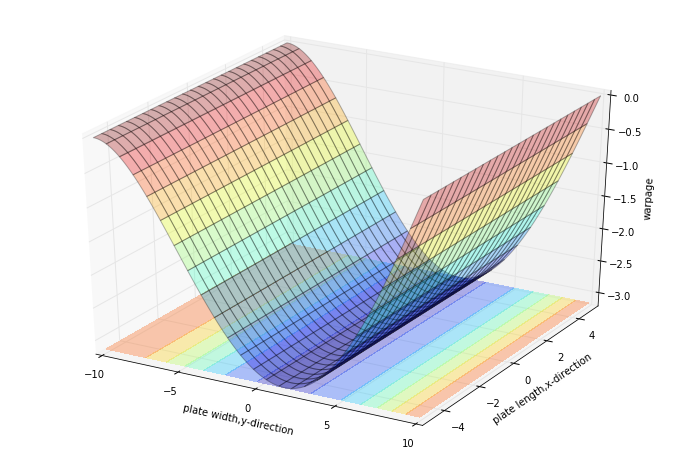

In [86]:
# plotting results 

# Sympy 3d plots
#from sympy.plotting import plot3d
#plot3d(w0f, (x,-a_/2,a_/2), (y,-b_/2,b_/2), title='beam deflection', xlabel='a,in', ylabel='b,in', zlabel='z,in');

# matplotlib plots
res = 250
X,Y = np.meshgrid(np.linspace(-a_/2,a_/2,res), np.linspace(-b_/2,b_/2,res))
w = sp.lambdify(x,w0f, "numpy")
fig = plt.figure('plate-warpage', figsize=(12, 8))

ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, w(X), cmap=mpl.cm.jet, alpha=0.3) 
cset = ax.contourf(X, Y, w(X), cmap=mpl.cm.jet, alpha=0.3, zdir='z', offset=np.min(w(X))) 
#cbar = plt.colorbar(cset)

ax.set_xlabel('plate width,y-direction')
ax.set_ylabel('plate length,x-direction')
ax.set_zlabel('warpage')

#ax.view_init(elev=25, azim=-58)           # elevation and angle
#ax.dist=10          # distance

# plot contour lines
#CS = plt.contour(X, Y, w(X), cmap=mpl.cm.jet) ; cbar = plt.colorbar(CS) ; plt.clabel(CS, inline=1, fontsize=10)

plt.show()

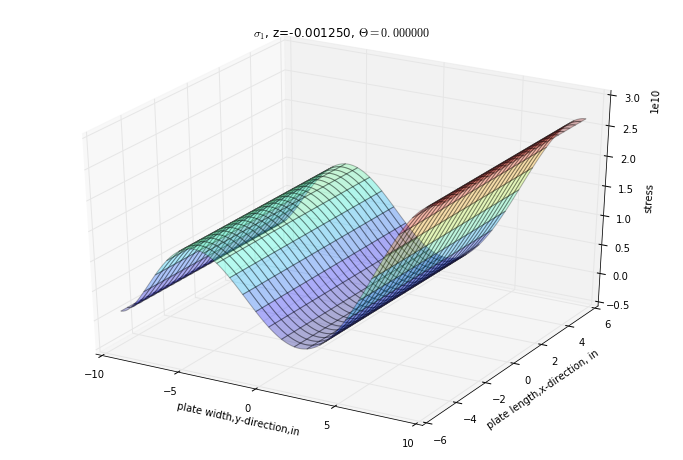

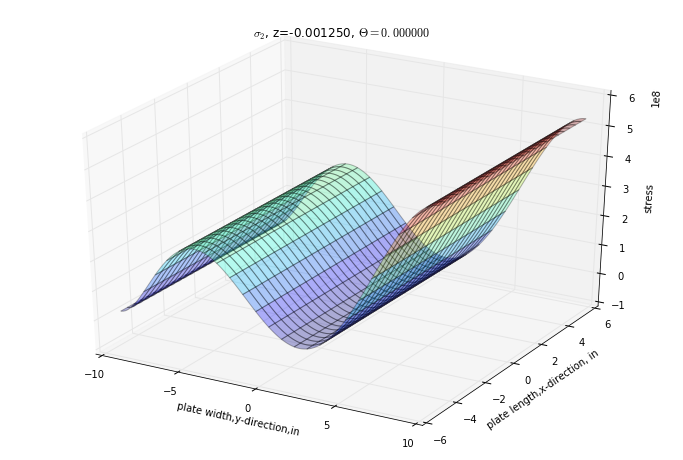

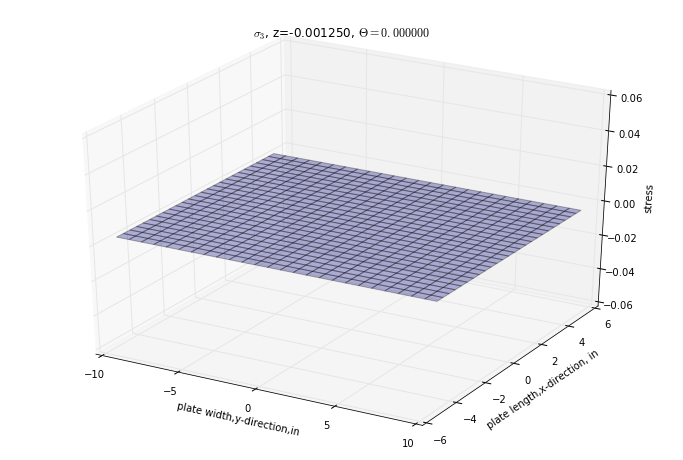

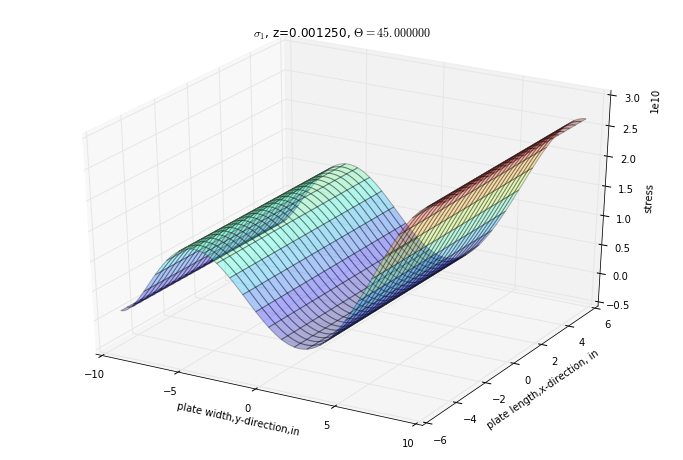

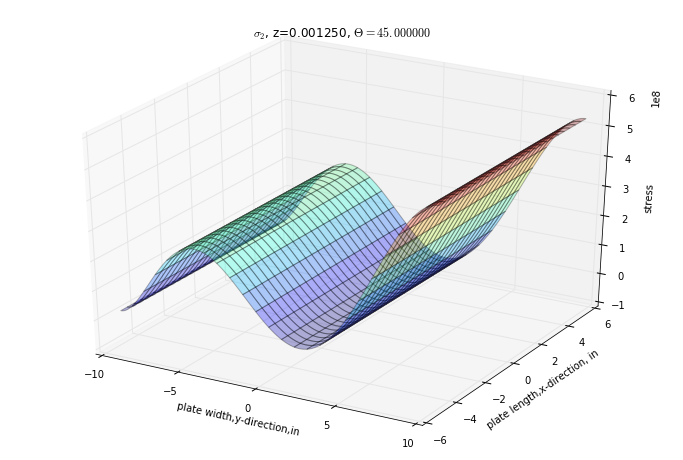

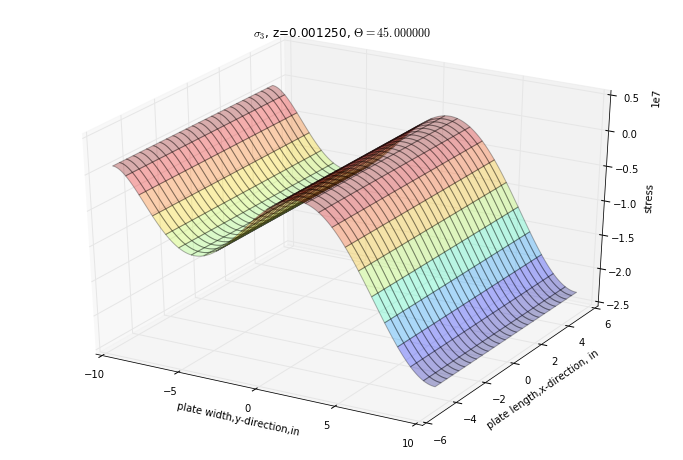

In [91]:
for i,k in enumerate(range(0,2*nply,2)):

    Qbar = T1s(plyangle[i])**-1 @ Q @ T2s(plyangle[i]) 
    
    # stress is calcuated at top and bottom of each ply
    
    sigmabar = Qbar @ epsbar.subs({z:zmid_[i]})
    
    eps = T2s(plyangle[i]) @ epsbar.subs({z:zmid_[i]})
    
    sigma = Q @ eps
    
    for p in range(3):
        #plot3d(sigma[p], (x,-a_/2,a_/2), (y,-b_/2,b_/2), title='stress_%i at z=%f'%((p+1),zmid_[i]), xlabel='a,in', ylabel='b,in', zlabel='z,in')
        sigmaplot = sp.lambdify(x,sigma[p], "numpy")
        
        fig = plt.figure(i, figsize=(12, 8))
        
        ax = fig.gca(projection='3d')
        ax.plot_surface(X, Y, sigmaplot(X), cmap=mpl.cm.jet, alpha=0.3)    
        #ax.contourf(X, Y, sigmaplot(X), cmap=mpl.cm.jet, alpha=0.3, zdir='z', offset=np.min(w(X))) 
        
        plt.title('$\sigma_%i$, z=%f, $\Theta=%f$ ' % ( (p+1),zmid_[i], plyangle[i]*180/np.pi) )
        ax.set_xlabel('plate width,y-direction,in')
        ax.set_ylabel('plate length,x-direction, in')
        ax.set_zlabel('stress')

        plt.show()